In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis
import numpy as np
# depthimage = get_bolt_depthimage()
# show_depthimage(depthimage)

Instantiating visualizer
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [2]:
# transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
# print(transform)
# depthimage = get_bolt_depthimage(transform)
# show_depthimage(depthimage)

In [3]:
# transform = get_random_transform()
# print(transform)
# depthimage = get_bolt_depthimage(transform)
# show_depthimage(depthimage)
# pcd = make_pointcloud(depthimage)
# print('Now I\'m a point cloud. Try moving me around!')
# vis.draw_geometries([pcd], moveable=False)

In [18]:
# make training data
n = 500
trans = np.array([get_random_transform() for _ in range(n)])
depth_img = np.array([get_bolt_depthimage(val) for val in trans])

In [5]:
# save training data

# train_data = np.array([np.array([trans[i], depth_img[i]], dtype=object) for i in range(n)])
# np.save('train_data.npy', train_data)

In [6]:
# file = np.load('train_data.npy', allow_pickle=True)
# depth_img = file[1]
# trans = file[0]

In [7]:
# # probably don't need
# def find_norm(vec):
#     mag = np.sqrt((vec[0] ** 2) + (vec[1] ** 2) + (vec[2] ** 2))
#     return np.array([vec[0] / mag, vec[1] / mag, vec[2] / mag])

In [50]:
# make model function
from sklearn.neighbors import KNeighborsRegressor

def model(X, y):
    m = KNeighborsRegressor()
    m.fit(X, y)
    return m

# def model2(X, y):
#     m = KNeighborsRegressor(weights='distance', metric='euclidean')
#     m.fit(X, y)
#     return m

# def model3(X, y):
#     m = KNeighborsRegressor(weights='distance', metric='manhattan')
#     m.fit(X, y)
#     return m

# def model(X, y):
#     m = KNeighborsRegressor(weights='distance', metric='chebyshev')
#     m.fit(X, y)
#     return m

# def model5(X, y):
#     m = KNeighborsRegressor(weights='distance', metric='wminkowski')
#     m.fit(X, y)
#     return m

In [51]:
# reshape data for model
print(depth_img.shape)
translation_flat = trans[:, :3, :].reshape(n, 12)
depth_flat = depth_img.reshape(n, (depth_img.shape[1] * depth_img.shape[2] * depth_img.shape[3]))

print(translation_flat.shape)
print(depth_flat.shape)

(500, 2, 1080, 1920)
(500, 12)
(500, 4147200)


In [52]:


# make model

m = model(depth_flat, translation_flat)
# m2 = model2(depth_flat, translation_flat)
# m3 = model3(depth_flat, translation_flat)
# m4 = model4(depth_flat, translation_flat)
# m5 = model5(depth_flat, translation_flat)

Truth
x=0.0, y=0.0, z=10.0
x_rotate=0.0°, y_rotate=20.0°, z_rotate=0.0°


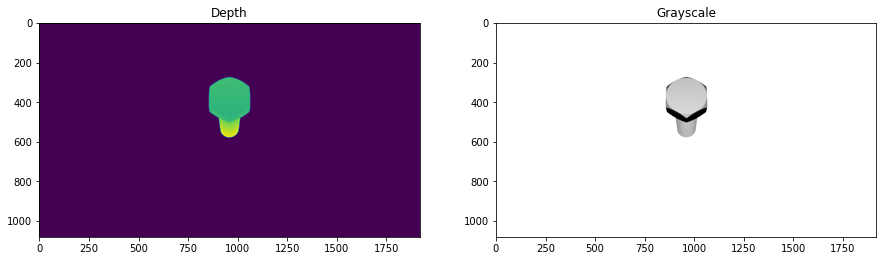

(1, 4147200)
(3, 4)
(3,)
Estimate
x=10.07, y=0.31, z=10.22
x_rotate=-0.02°, y_rotate=6.52°, z_rotate=-3.76°

Error: 7.04


In [53]:
#import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    transformed_depthimage = np.array(transformed_depthimage)
    # print(transformed_depthimage.shape)
    transformed_depthimage = transformed_depthimage.reshape(1, (transformed_depthimage.shape[0] 
                                            * transformed_depthimage.shape[1] * transformed_depthimage.shape[2]))
    print(transformed_depthimage.shape)
    prediction = m.predict(transformed_depthimage)
    prediction = prediction.reshape(3,4)
    print(prediction.shape)
    rot = prediction[:, :3]
    translation = prediction[:, -1:].reshape(3,)
    print(translation.shape)
    return TransformationMatrix.compose(rot, translation)
#     orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
#     orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

#     trns_pcd = make_pointcloud(transformed_depthimage)
#     trns_center = trns_pcd.get_center()
#     translation = (trns_center - orig_center)
#     rot = np.zeros(3) # dummy values
#     rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
#     rot = R.from_euler('xyz', rot).as_matrix()
#     return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,0,10,0,20,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
#m = model(depth_flat, translation_flat)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

# ###### TESTING ####
# estimate = estimator(transformed, m2, debug=False)
# print('Estimate')
# print(estimate)
# from utility.pose_estimation import transform_error, evaluate_random

# print('\nError:', transform_error(estimate, transform).round(3))

# estimate = estimator(transformed, m3, debug=False)
# print('Estimate')
# print(estimate)
# from utility.pose_estimation import transform_error, evaluate_random

# print('\nError:', transform_error(estimate, transform).round(3))

# estimate = estimator(transformed, m4, debug=False)
# print('Estimate')
# print(estimate)
# from utility.pose_estimation import transform_error, evaluate_random

# print('\nError:', transform_error(estimate, transform).round(3))

# estimate = estimator(transformed, m5, debug=False)
# print('Estimate')
# print(estimate)
# from utility.pose_estimation import transform_error, evaluate_random

# print('\nError:', transform_error(estimate, transform).round(3))

In [45]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

4.992021474532707

In [46]:
import os
os.environ["DISCORD_USERNAME"] = "Katherine_Stevens#0321"

In [47]:
from utility.pose_estimation import make_submission, test_images
from tqdm import tqdm

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


  0%|                                                   | 0/200 [00:00<?, ?it/s]

ValueError: X has 4005120 features, but KNeighborsRegressor is expecting 4147200 features as input.

In [ ]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

In [ ]:
get_myscores(Challenge.POSE)

# Robot Control Challenge

In [ ]:
from utility.remote_env import RobotorqueEnvironment

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])
